# Skeleton plots that shows the synapse placement of all 7 clusters by module on the oviINr arbor
Steps in this file:
- Import skeleton, using 2d skeletons segments (kind of buggy)
- Import partition data for input connectome
- Import synapse location data
- Process dataframes so that synapse location and cluster are on the same dataframe
- Assign colors with a dictionary and then map
- Plot segments and synapses with legend

Written by Rhessa Weber Langstaff

In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import bokeh
import bokeh.palettes
from bokeh.plotting import figure, output_notebook, show, output_file, gridplot
from bokeh.io import export_svg, export_png
from bokeh.models import Legend, LegendItem
import os
from neuprint import Client, fetch_adjacencies
# settings
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["font.sans-serif"] = "Helvetica"
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

auth_token_file = open("flybrain.auth.txt", 'r') # need file containing the authentication token
auth_token = next(auth_token_file).strip()
try:
    np_client = Client('neuprint.janelia.org', dataset='hemibrain:v1.2.1', token=auth_token)
except:
    np_client = None

output_notebook()

Loading BokehJS ...

### Prepping data for plotting

In [3]:
# Create skeleton for later usage (inspired from Prof G.'s notebook ovi_specs_sandbox.ipynb)
# body Ids of oviINs
ovi_r = 423101189
ovi_l = 485934965
ovis = [ovi_r, ovi_l]

# cretae skeleton for both oviINs
skeletons = []

s = np_client.fetch_skeleton(ovi_r, format='pandas')
s['bodyId'] = ovi_r
s['color'] = bokeh.palettes.Greys[3][1]
skeletons.append(s)

skeletons = pd.concat(skeletons, ignore_index=True)

In [4]:
# pre-synaptic oviINs
pre_n, pre_conn = fetch_adjacencies(None, ovi_r)
#Group pre_conn by connection pair, dropping the roi column, and summing the weight column
pre_conn = pre_conn.groupby(['bodyId_pre', 'bodyId_post']).sum().reset_index()

In [5]:
pre_conn

,bodyId_pre,bodyId_post,roi,weight
0,234630133,423101189,CRE(R),2
1,263674097,423101189,SMP(R),2
2,266187480,423101189,SMP(R),1
3,266187559,423101189,SMP(R),3
4,267214250,423101189,SMP(R),9
...,...,...,...,...
2519,5901231318,423101189,SMP(L),1
2520,5901232053,423101189,SMP(R),3
2521,6400000773,423101189,SMP(R),2
2522,7112622044,423101189,SIP(R)SMP(R)SMP(L),3


In [6]:
# Join parent nodes
segments = skeletons.merge(skeletons, left_on=['bodyId', 'link'], right_on=['bodyId', 'rowId'], suffixes=['_child', '_parent'])

# import full connectome data and location data
ovi_node_df  = pd.read_csv('modularity_runs/0.0/0-0_98765.txt', header=None, sep=' ', names=['id', "0.0"])

# Import synapse location data for pre-synaptic sites
ovi_pre_syns = pd.read_csv('data/ovi_pre_syns.csv')

ovi_pre_syns

,bodyId_pre,bodyId_post,roi_pre,roi_post,x_pre,y_pre,z_pre,x_post,y_post,z_post,confidence_pre,confidence_post,type_pre,type_post
0,989228019,423101189,CRE(R),CRE(R),22857,34611,17485,22825,34624,17464,0.998,0.633171,FB5V,oviIN
1,988909130,423101189,CRE(R),CRE(R),19523,31096,21707,19509,31112,21693,0.969,0.528840,FB5V,oviIN
2,988567837,423101189,LAL(R),LAL(R),23100,27659,23824,23074,27659,23801,0.970,0.459446,FB4G,oviIN
3,987842109,423101189,SMP(R),SMP(R),19041,33090,14598,19047,33072,14598,0.973,0.974019,NaN,oviIN
4,987273073,423101189,CRE(R),CRE(R),19347,27826,15348,19351,27806,15376,0.943,0.595921,NaN,oviIN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21619,1006928515,423101189,IB,IB,22664,14840,19749,22651,14823,19757,0.994,0.865103,CL300,oviIN
21620,1005952640,423101189,IB,IB,21998,15625,18990,22007,15603,18991,0.996,0.929040,IB058,oviIN
21621,1005952640,423101189,IB,IB,22998,15275,23049,23014,15272,23060,0.835,0.780000,IB058,oviIN
21622,1005952640,423101189,IB,IB,23034,15380,23131,23048,15364,23146,0.986,0.905853,IB058,oviIN


In [7]:
# edit dataframes for easy merging
ovi_clusters = ovi_node_df[['id', '0.0']].copy()
ovi_locs = ovi_pre_syns[['bodyId_pre', 'x_post', 'y_post', 'z_post', 'type_pre']].copy()

# merge synapse data onto cluster data
ovi_plotting = ovi_clusters.merge(ovi_locs, left_on='id', right_on='bodyId_pre').drop(columns='bodyId_pre')
ovi_plotting

,id,0.0,x_post,y_post,z_post,type_pre
0,1003215282,1,24282,16879,21874,CL229
1,1005952640,2,22007,15603,18991,IB058
2,1005952640,2,23014,15272,23060,IB058
3,1005952640,2,23048,15364,23146,IB058
4,1006928515,3,22651,14823,19757,CL300
...,...,...,...,...,...,...
18777,987117151,2,17185,30699,23308,LAL010
18778,987273073,6,19351,27806,15376,NaN
18779,988567837,5,23074,27659,23801,FB4G
18780,988909130,5,19509,31112,21693,FB5V


In [8]:
# Create color dictionary where each number in column 0.0 is assigned a color
#colors = ['', '#', '#e7cf57', '#ff6a88', '#', '#', '#9fad2b']
color_dict = {1: '#4e90d3', 2: '#9467bd', 3: '#e7cf57', 4: '#ff6a88', 5: '#5cc9ff', 6: '#3a9f82', 7: '#9fad2b'}

# Merge color dictionary onto dataframe
ovi_plotting['color'] = ovi_plotting['0.0'].map(color_dict)
ovi_plotting

,id,0.0,x_post,y_post,z_post,type_pre,color
0,1003215282,1,24282,16879,21874,CL229,#4e90d3
1,1005952640,2,22007,15603,18991,IB058,#9467bd
2,1005952640,2,23014,15272,23060,IB058,#9467bd
3,1005952640,2,23048,15364,23146,IB058,#9467bd
4,1006928515,3,22651,14823,19757,CL300,#e7cf57
...,...,...,...,...,...,...,...
18777,987117151,2,17185,30699,23308,LAL010,#9467bd
18778,987273073,6,19351,27806,15376,NaN,#3a9f82
18779,988567837,5,23074,27659,23801,FB4G,#5cc9ff
18780,988909130,5,19509,31112,21693,FB5V,#5cc9ff


In [9]:
# Merge connections and modularity data
pre_only = pre_conn[['bodyId_pre', 'weight']].copy()
pre_conn_mod = pre_only.merge(ovi_clusters, left_on='bodyId_pre', right_on='id', how='right').drop(columns='id')
pre_conn_mod

,bodyId_pre,weight,0.0
0,1003215282,1,1
1,1005952640,3,2
2,1006928515,1,3
3,1007260806,7,3
4,1008024276,1,4
...,...,...,...
1827,987117151,14,2
1828,987273073,1,6
1829,988567837,1,5
1830,988909130,1,5


In [10]:
# Merge type onto dataframe using pre_n
pre_conn_mod_types = pre_conn_mod.merge(pre_n[['bodyId', 'type']], left_on='bodyId_pre', right_on='bodyId', how='left')
pre_conn_mod_types

,bodyId_pre,weight,0.0,bodyId,type
0,1003215282,1,1,1003215282,CL229
1,1005952640,3,2,1005952640,IB058
2,1006928515,1,3,1006928515,CL300
3,1007260806,7,3,1007260806,CL301
4,1008024276,1,4,1008024276,FB5N
...,...,...,...,...,...
1827,987117151,14,2,987117151,LAL010
1828,987273073,1,6,987273073,None
1829,988567837,1,5,988567837,FB4G
1830,988909130,1,5,988909130,FB5V


In [11]:
# Getting the strongest celltype inputs 
c1 = pre_conn_mod_types[pre_conn_mod_types['0.0'] == 1].drop(columns=['bodyId_pre', 'bodyId'])
c1_grouped = c1.groupby('type').sum().sort_values('weight', ascending=False)
c1_grouped.head(20)

,weight,0.0
type,,
SMP052,361,4
SMP176,287,1
SMP383,281,2
SMP051,157,2
SMP237,135,1
SMP520,125,5
SMP314,106,2
SMP464,97,6
SMP516,93,2


In [12]:
# get top 20 celltypes for each cluster in 0.0 using the process above and add to a dataframe
top_20 = pd.DataFrame()
for i in range(1, 8):
    c = pre_conn_mod_types[pre_conn_mod_types['0.0'] == i].drop(columns=['bodyId_pre', 'bodyId'])
    c_grouped = c.groupby('type').sum().sort_values('weight', ascending=False).head(20)
    c_grouped['cluster'] = i
    top_20 = pd.concat([top_20, c_grouped])

top_20


,weight,0.0,cluster
type,,,
SMP052,361,4,1
SMP176,287,1,1
SMP383,281,2,1
SMP051,157,2,1
SMP237,135,1,1
...,...,...,...
pC1a,34,14,7
SMP589,32,14,7
SLP212,31,35,7


In [13]:
# reset index for plotting
top_20 = top_20.reset_index()
top_20

,type,weight,0.0,cluster
0,SMP052,361,4,1
1,SMP176,287,1,1
2,SMP383,281,2,1
3,SMP051,157,2,1
4,SMP237,135,1,1
...,...,...,...,...
135,pC1a,34,14,7
136,SMP589,32,14,7
137,SLP212,31,35,7
138,SMP032,19,7,7


### Function for skeleton plotting

In [42]:
# Plot the skeleton plot so it just shows one cluster at a time, should be 7 plots
#clusters = [1, 2, 3, 4, 5, 6, 7]
def cluster_nt(df, cluster_list, all_one=False):
    """ Function to plot the skeleton of the oviINs with the synapse locations for each module.

    Parameters  
    ----------
    df : pandas.DataFrame
        DataFrame containing the synapse locations and module information.
    cluster_list : list
        List of clusters to plot.
    all_one : bool
        If True, plot all clusters in one figure, otherwise plot each module in a separate figure. 
    """
    if all_one:
        fig, ax = plt.subplots(3,3,figsize=(4.5, 6))
        for i, cluster in enumerate(cluster_list):
            ax[int(i /3), i % 3].invert_yaxis()  # Flip the y-axis 
            # drop y axis
            ax[int(i / 3), i % 3].set_yticks([])
            ax[int(i / 3), i % 3].set_xticks([])
            df_x = df[df['0.0']==cluster]
            for index, row in segments.iterrows():
                ax[int(i / 3), i % 3].plot([row['x_child'], row['x_parent']], [row['z_child'], row['z_parent']], c=row['color_child'], linewidth= 0.5, zorder=1)
            # Plot skeleton 6 times, each time with a different cluster
            ax[int(i / 3), i % 3].scatter(df_x['x_post'], df_x['z_post'], color=df_x["color"], s=1, zorder=10)
            # Set title for the subplot
            ax[int(i / 3), i % 3].set_title('Cluster ' + str(cluster))
    else:
    # Create a new plot for each module
        for cluster in cluster_list:
            # create plot with two subplots
            fig, ax = plt.subplots(1, 2) # allows for formatting legend into figure in adobe Illustrator
            fig.set_figwidth(6.85)
            fig.set_figheight(4.3)
            ax[0].invert_yaxis()
            ax[1].invert_yaxis()
            
            # drop axis
            ax[0].set_yticks([])
            ax[0].set_xticks([])

            # drop axis
            ax[1].set_yticks([])
            ax[1].set_xticks([])

            df_x = df[df['0.0']==cluster]
            for index, row in segments.iterrows():
                ax[0].plot([row['x_child'], row['x_parent']], [row['z_child'], row['z_parent']], c=row['color_child'], linewidth= 0.2, zorder=1)
                ax[1].plot([row['y_child'], row['y_parent']], [row['z_child'], row['z_parent']], c=row['color_child'], linewidth= 0.2, zorder=1)

            # Plot skeleton 6 times, each time with a different cluster
            ax[0].scatter(df_x['x_post'], df_x['z_post'], color=df_x["color"], s=1, zorder=10)
            ax[1].scatter(df_x['y_post'], df_x['z_post'], color=df_x["color"], s=1, zorder=10)
            # Set title for the subplot
            #ax[0].set_title('Module ' + str(cluster) + ' (front)')
            #ax[1].set_title('Module ' + str(cluster) + ' (lateral)')
            
            # Legend should be the top 20 celltypes for each cluster
            handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_dict[cluster], markersize=5) for i in range(20)]
            labels = top_20[top_20['cluster'] == cluster]['type'].values
            ax[1].legend(handles, labels, loc='center right', bbox_to_anchor=(1.35, 0.5))

            plt.tight_layout()

            # dont display figure outline
            ax[0].spines['top'].set_visible(False)
            ax[0].spines['right'].set_visible(False)
            ax[0].spines['bottom'].set_visible(False)
            ax[0].spines['left'].set_visible(False)

            ax[1].spines['top'].set_visible(False)
            ax[1].spines['right'].set_visible(False)
            ax[1].spines['bottom'].set_visible(False)
            ax[1].spines['left'].set_visible(False)
            plt.savefig('figures/supp_syn_sites_mod' + str(cluster) + '.pdf', bbox_inches='tight')

            # create a new figure for the legend
            #fig_legend, ax_legend = plt.subplots(figsize=(2, 2.4278))
            #ax_legend.axis('off')
            #ax_legend.legend(handles, labels, loc='center', title='Top 20 cell types')
            
            #plt.tight_layout()
            #plt.savefig('figures/supp_syn_sites_edit_legend' + str(cluster) + '.pdf', bbox_inches='tight')

        plt.box(False)
        




### Running function for plots

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


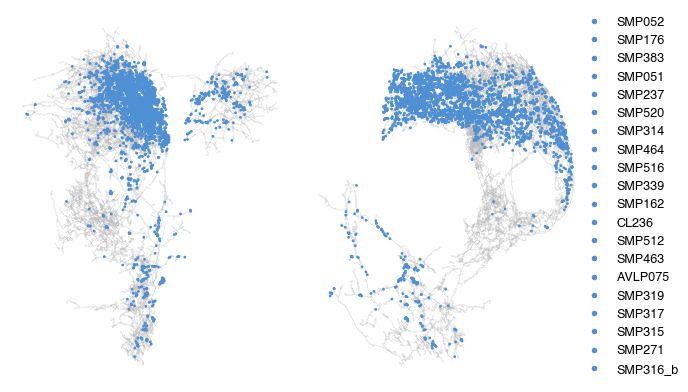

In [43]:
# Plot the skeleton plot for module 1, takes about a min per module
clusters = [1]

cluster_nt(ovi_plotting, clusters)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


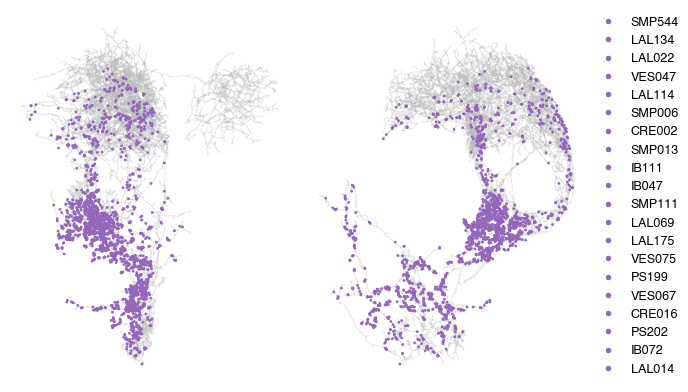

In [44]:
# module 2
cluster_nt(ovi_plotting, [2])

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


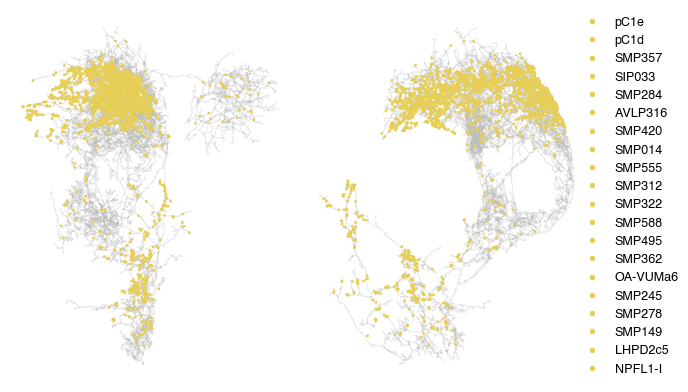

In [45]:
# module 3
cluster_nt(ovi_plotting, [3])

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know

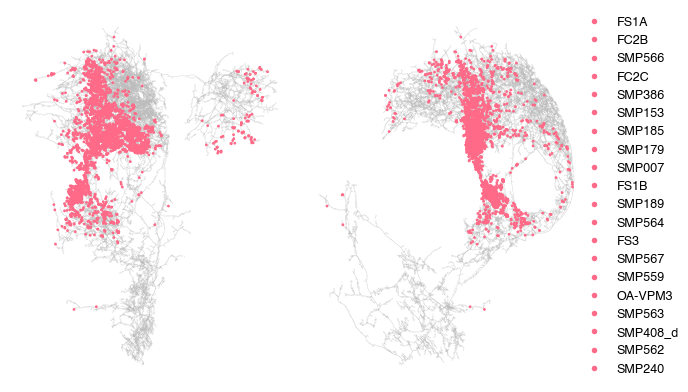

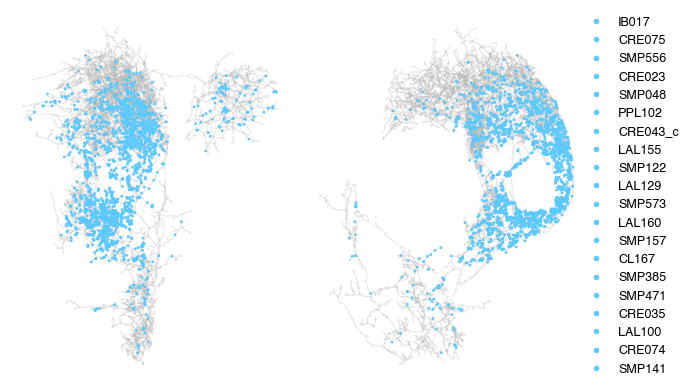

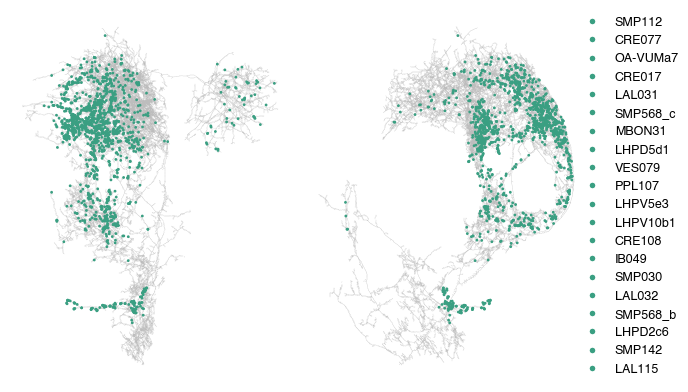

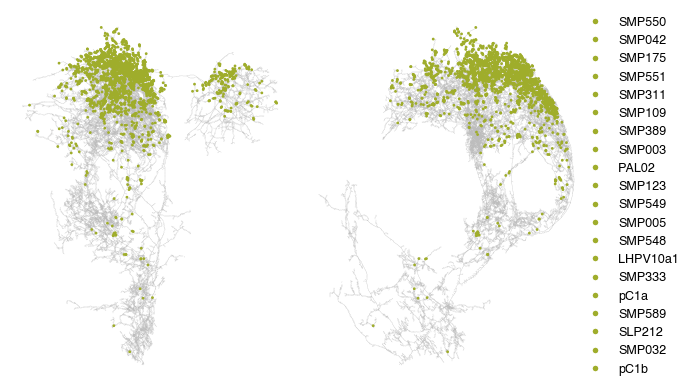

In [46]:
# module 4, 5, 6, 7 
cluster_nt(ovi_plotting, [4, 5, 6, 7])